Import important parameter

In [1]:
inputsize = 47**2
e = 0.0512

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 16.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 16*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <100:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

sqrtinputsize = int(np.sqrt(inputsize))
sqrtmidputsize = int(sqrtinputsize/2)
midputsize = int(sqrtmidputsize**2)
sqrtoutputsize = int(sqrtmidputsize/2)
outputsize = int(sqrtoutputsize**2)

h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R1 = Restriction(inputsize)
R2 = Restriction(midputsize)
R  = np.matmul(R2, R1)
P = 16*np.transpose(R)

GMM on fine grid

In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 7.875166417640066
Interation = 1
Residual = 3.501258713522209
Interation = 2
Residual = 2.0445253109825585
Interation = 3
Residual = 1.2556311578740422
Interation = 4
Residual = 0.79043998092163
Interation = 5
Residual = 0.5077671229957404
Interation = 6
Residual = 0.3333706549439764
Interation = 7
Residual = 0.22433975229120337
Interation = 8
Residual = 0.15504318288141133
Interation = 9
Residual = 0.11003820869822396
Interation = 10
Residual = 0.08002444650711592
Interation = 11
Residual = 0.059413745192013666
Interation = 12
Residual = 0.04484411559654537
Interation = 13
Residual = 0.034273788071017885
Interation = 14
Residual = 0.02643827487057258
Interation = 15
Residual = 0.02053174677638319
Interation = 16
Residual = 0.01602291499851214
Interation = 17
Residual = 0.012549073078510053
Interation = 18
Residual = 0.009854556449281592
Interation = 19
Residual = 0.0077542199726368935
Interation = 20
Residual = 0.006111076696582011
Interation = 21
Residual = 0.0048220942191

Error GMM on fine grid

In [6]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
1.4302932073510095
L2 norm: 
0.07921818954665408
H1 norm: 
1.0611381960247304
Energy norm: 
0.11004716592783026
L2 norm: 
0.15843637909330818
H1 norm: 
0.11509431947290517


Solution

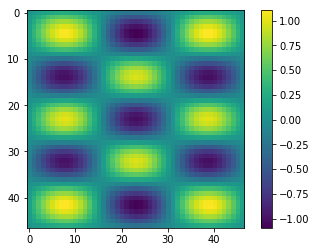

In [7]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

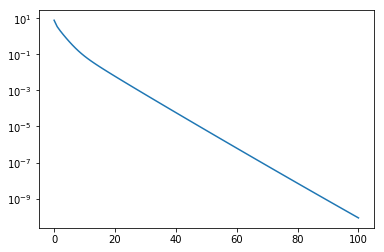

In [8]:
plt.semilogy(GMM_Res)

Radius

In [9]:
GMM_Radius = rho(inputsize,A1.to_full(),16*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.8409801108876742


Global DMM optimization

In [10]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-6,accept_radius =
                                                           GMM_Radius*10,step_length =  1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.8426052225745653
L = 0.03
rho = 0.8426008102955566
L = 0.04
rho = 0.8425951849694503
L = 0.05
rho = 0.8425884194416766
L = 0.060000000000000005
rho = 0.8425805828556224
L = 0.07
rho = 0.8425717408314425
L = 0.08
rho = 0.8425619556391474
L = 0.09
rho = 0.8425512863654356
L = 0.09999999999999999
rho = 0.8425397890739362
L = 0.10999999999999999
rho = 0.8425275169586807
L = 0.11999999999999998
rho = 0.8425145204907424
L = 0.12999999999999998
rho = 0.8425008475580725
L = 0.13999999999999999
rho = 0.842486543598632
L = 0.15
rho = 0.8424716517269681
L = 0.16
rho = 0.8424562128544297
L = 0.17
rho = 0.8424402658032291
L = 0.18000000000000002
rho = 0.8424238474145904
L = 0.19000000000000003
rho = 0.8424069926512265
L = 0.20000000000000004
rho = 0.8423897346943944
L = 0.21000000000000005
rho = 0.8423721050357816
L = 0.22000000000000006
rho = 0.8423541335644733
L = 0.23000000000000007
rho = 0.8423358486492462
L = 0.24000000000000007
rho = 0.8423172772164287
L

the 27 steps
rho = 0.840967750445328
the 28 steps
rho = 0.8409676498420837
the 29 steps
rho = 0.8409675492405082
the 30 steps
rho = 0.8409674486406008
the 31 steps
rho = 0.8409673480423607
the 32 steps
rho = 0.840967247445787
the 33 steps
rho = 0.8409671468508787
the 34 steps
rho = 0.8409670462576351
the 35 steps
rho = 0.8409669456660553
the 36 steps
rho = 0.8409668450761386
the 37 steps
rho = 0.8409667444878839
the 38 steps
rho = 0.8409666439012905
the 39 steps
rho = 0.8409665433163576
the 40 steps
rho = 0.8409664427330842
the 41 steps
rho = 0.8409663421514695
the 42 steps
rho = 0.8409662415715126
the 43 steps
rho = 0.8409661409932128
the 44 steps
rho = 0.8409660404165691
the 45 steps
rho = 0.8409659398415809
the 46 steps
rho = 0.8409658392682471
the 47 steps
rho = 0.8409657386965668
the 48 steps
rho = 0.8409656381265393
the 49 steps
rho = 0.8409655375581638
the 50 steps
rho = 0.8409654369914394
the 51 steps
rho = 0.8409653364263654
the 52 steps
rho = 0.8409652358629406
the 53 steps
r

Global DMM on fine grid

In [11]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 7.875134639461838
Interation = 1
Residual = 3.501005093594299
Interation = 2
Residual = 2.0443231978882657
Interation = 3
Residual = 1.2554670955638878
Interation = 4
Residual = 0.7903126794522429
Interation = 5
Residual = 0.5076725911738071
Interation = 6
Residual = 0.33330278368972405
Interation = 7
Residual = 0.22429205797645346
Interation = 8
Residual = 0.15500993622730583
Interation = 9
Residual = 0.11001488952046645
Interation = 10
Residual = 0.0800077702306538
Interation = 11
Residual = 0.05940147256455246
Interation = 12
Residual = 0.04483478990052453
Interation = 13
Residual = 0.03426648773936805
Interation = 14
Residual = 0.026432420888968283
Interation = 15
Residual = 0.020526969987956386
Interation = 16
Residual = 0.016018971929213574
Interation = 17
Residual = 0.012545795380860618
Interation = 18
Residual = 0.009851821530874058
Interation = 19
Residual = 0.007751934193479457
Interation = 20
Residual = 0.006109165743598044
Interation = 21
Residual = 0.00482049748

Error DMM on fine grid

In [12]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
1.4302932073509995
L2 norm: 
0.07921818954665348
H1 norm: 
1.0611381960247244
Energy norm: 
0.11004716592782948
L2 norm: 
0.158436379093307
H1 norm: 
0.11509431947290452


Solution

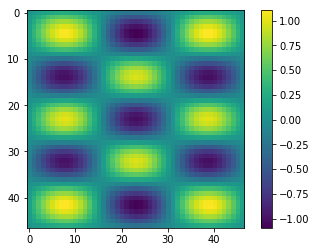

In [13]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

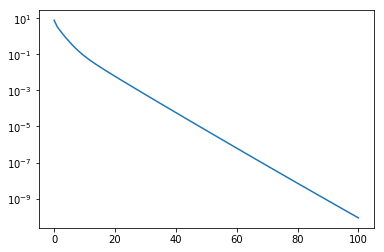

In [14]:
plt.semilogy(DMM_Res)

Radius

In [15]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.840960511227091


Rrestriction matrix after optimization

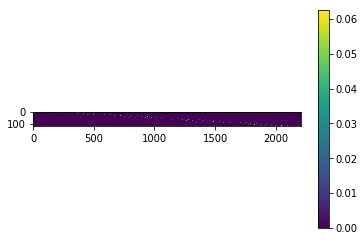

In [16]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

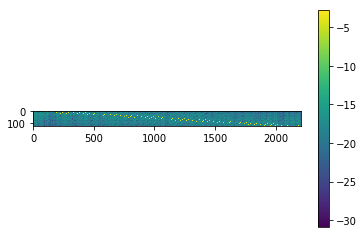

In [17]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

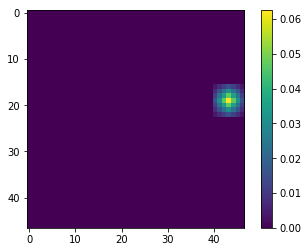

In [18]:
basis1 = Rnew[int(0.45*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

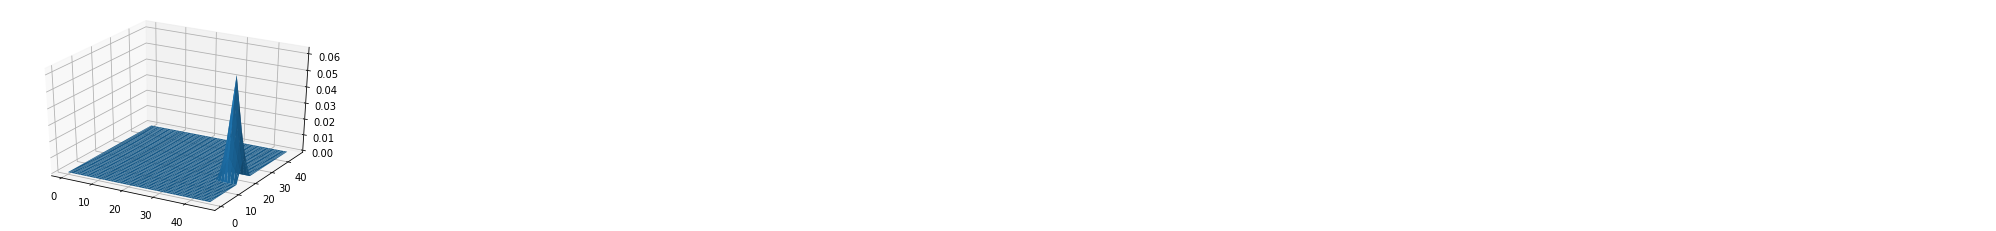

In [19]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,basis1)
plt.show()

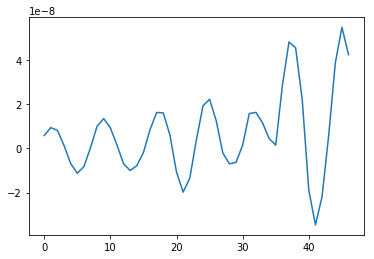

In [20]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

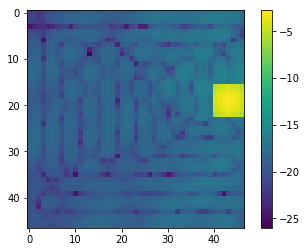

In [21]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

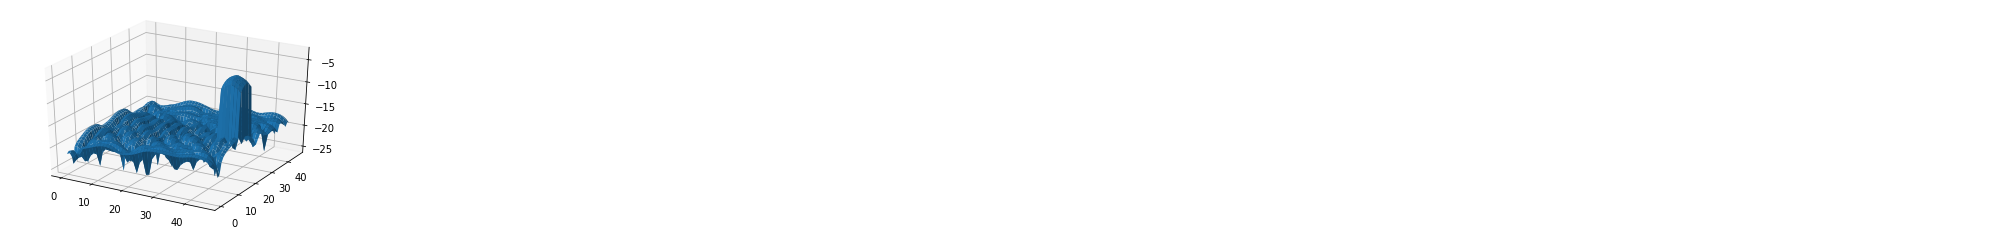

In [22]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

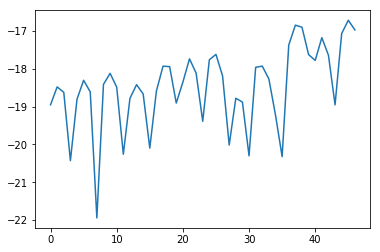

In [23]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
3.565260650418881
L2 norm: 
0.11334109971304583
H1 norm: 
2.566494022766666
Energy norm: 
0.2743121678521154
L2 norm: 
0.2266821994260917
H1 norm: 
0.27836985237945766


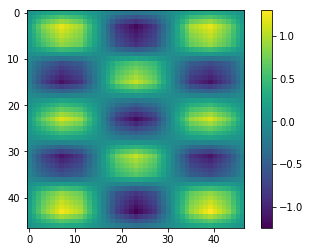

In [24]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [25]:
import os
os.system("say 'The program has finished, Please check the results'")

0